In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm  
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device：{device}")

device：cpu


In [8]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = self._read_images(images_path)
        self.labels = self._read_labels(labels_path)
        self.transform = transform
        self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def _read_images(self, path):
        
        with open(path, 'rb') as f:
            # First 4 bytes: magic number
            # Next 4 bytes: number of images
            # Next 4 bytes: height
            # Next 4 bytes: width
            magic = int.from_bytes(f.read(4), byteorder='big')
            num_imgs = int.from_bytes(f.read(4), byteorder='big')
            height = int.from_bytes(f.read(4), byteorder='big')
            width = int.from_bytes(f.read(4), byteorder='big')
            # Read pixel values (uint8) and reshape to (num, height, width)
            imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_imgs, height, width)
        return imgs

    def _read_labels(self, path):
       
        with open(path, 'rb') as f:
            # First 4 bytes: magic number
            # Next 4 bytes: number of labels
            magic = int.from_bytes(f.read(4), byteorder='big')
            num_labels = int.from_bytes(f.read(4), byteorder='big')
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Image: (H, W) → (1, H, W) since PyTorch expects channel first
        # Convert to float32 and normalize to [0,1]
        image = self.images[idx].astype(np.float32) / 255.0
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Dataset path
data_path = "/kaggle/input/fashionmnist"
train_images_path = os.path.join(data_path, "train-images-idx3-ubyte")
train_labels_path = os.path.join(data_path, "train-labels-idx1-ubyte")
test_images_path = os.path.join(data_path, "t10k-images-idx3-ubyte")
test_labels_path = os.path.join(data_path, "t10k-labels-idx1-ubyte")

# Data transformations (simple augmentation: random horizontal flip)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probability horizontal flip
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Create dataset and dataloader
train_dataset = FashionMNISTDataset(
    train_images_path, train_labels_path, transform=transform
)
test_dataset = FashionMNISTDataset(
    test_images_path, test_labels_path, transform=transforms.Normalize(mean=[0.5], std=[0.5])
)

# Batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# View basic dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")  # (1, 28, 28)
print(f"Class names: {train_dataset.classes}")


Number of training samples: 60000
Number of test samples: 10000
Image shape: torch.Size([1, 28, 28])
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Convolution layers: feature extraction
        self.conv_layers = nn.Sequential(
            # Input: (batch, 1, 28, 28) → Output: (batch, 32, 26, 26)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling: (batch, 32, 13, 13)
            
            # Input: (batch, 32, 13, 13) → Output: (batch, 64, 11, 11)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling: (batch, 64, 5, 5)
        )
        
        # Fully connected layers: classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten: (batch, 64*5*5) = (batch, 1600)
            nn.Linear(64 * 5 * 5, 128),  # 1600 → 128
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(128, num_classes)  # 128 → 10 (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model and move to device
model = SimpleCNN(num_classes=10).to(device)
print(model)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
# Loss function (cross entropy for classification)
criterion = nn.CrossEntropyLoss()
# Optimizer (Adam with learning rate 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()  # Training mode (enables dropout)
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation + update
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
        
        # Metrics calculation
        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)  # Predicted classes
        total_correct += (predicted == labels).sum().item()
        total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def test_epoch(model, loader, criterion, device):
    """Test one epoch"""
    model.eval()  # Evaluation mode (disables dropout)
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradient computation → memory & speed efficient
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy



Epoch 1/10


Testing: 100%|██████████| 157/157 [00:02<00:00, 52.39it/s]


Train Loss: 0.6156 | Train Accuracy: 0.7770
Test Loss: 0.4092 | Test Accuracy: 0.8486

Epoch 2/10


Testing: 100%|██████████| 157/157 [00:02<00:00, 53.08it/s]


Train Loss: 0.4147 | Train Accuracy: 0.8514
Test Loss: 0.3442 | Test Accuracy: 0.8746

Epoch 3/10


Testing: 100%|██████████| 157/157 [00:02<00:00, 53.45it/s]


Train Loss: 0.3611 | Train Accuracy: 0.8714
Test Loss: 0.3129 | Test Accuracy: 0.8847

Epoch 4/10


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.85it/s]


Train Loss: 0.3264 | Train Accuracy: 0.8835
Test Loss: 0.2932 | Test Accuracy: 0.8893

Epoch 5/10


Testing: 100%|██████████| 157/157 [00:02<00:00, 54.18it/s]


Train Loss: 0.3051 | Train Accuracy: 0.8905
Test Loss: 0.2814 | Test Accuracy: 0.8964

Epoch 6/10


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.92it/s]


Train Loss: 0.2875 | Train Accuracy: 0.8957
Test Loss: 0.2763 | Test Accuracy: 0.8965

Epoch 7/10


Testing: 100%|██████████| 157/157 [00:03<00:00, 49.98it/s]


Train Loss: 0.2755 | Train Accuracy: 0.9002
Test Loss: 0.2757 | Test Accuracy: 0.8999

Epoch 8/10


Testing: 100%|██████████| 157/157 [00:04<00:00, 38.31it/s]


Train Loss: 0.2659 | Train Accuracy: 0.9042
Test Loss: 0.2582 | Test Accuracy: 0.9066

Epoch 9/10


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.72it/s]


Train Loss: 0.2543 | Train Accuracy: 0.9083
Test Loss: 0.2598 | Test Accuracy: 0.9077

Epoch 10/10


Testing: 100%|██████████| 157/157 [00:02<00:00, 52.93it/s]


Train Loss: 0.2449 | Train Accuracy: 0.9110
Test Loss: 0.2537 | Test Accuracy: 0.9052


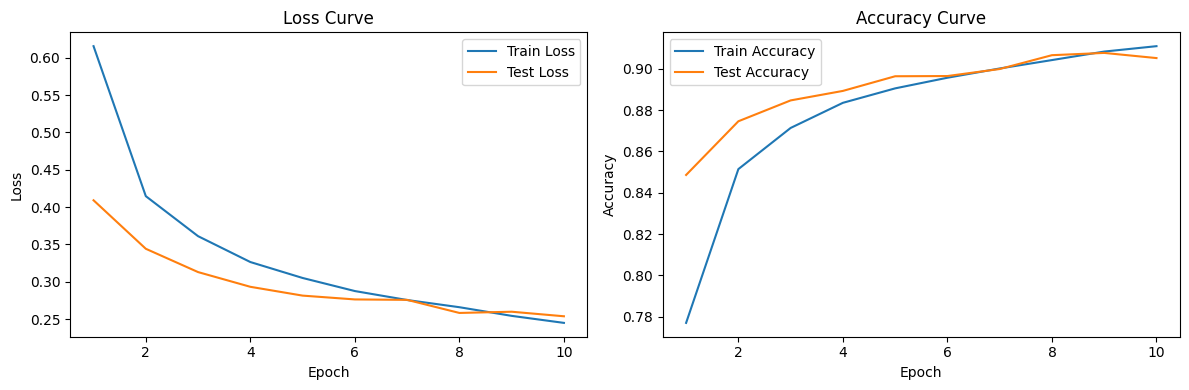

Model saved successfully!


In [12]:
# Training parameters
num_epochs = 10  # Number of training epochs (can increase; 10 is enough to converge)
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Visualize training curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()

# Save model (optional)
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")
print("Model saved successfully!")
